### MCMC Markov Chain Monte Carlo

modified from: https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter3_MCMC/Ch3_IntroMCMC_PyMC3.ipynb

When we setup a Bayesian inference problem with $N$ unknowns, we are implicitly creating an $N$ dimensional space for the prior distributions to exist in. Associated with the space is an additional dimension, which we can describe as the surface, or curve, that sits on top of the space, that reflects the prior probability of a particular point. The surface on the space is defined by our prior distributions. 

F.i. if 2 priors are $\text{Exp}(3)$ and $\text{Exp}(10)$, then the space is all positive numbers on the 2-D plane, and the surface induced by the priors looks like a water fall that starts at the point (0,0) and flows over the positive numbers.

The plots below visualize this. The more more yellow the color, the more prior probability is assigned to that location. Conversely, areas with darker blue represent that our priors assign very low probability to that location.

In [8]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pymc3 as pm
import theano.tensor as T
import sys
sys.path.insert(0, 'helper_functions/')
from utilities import remove_borders

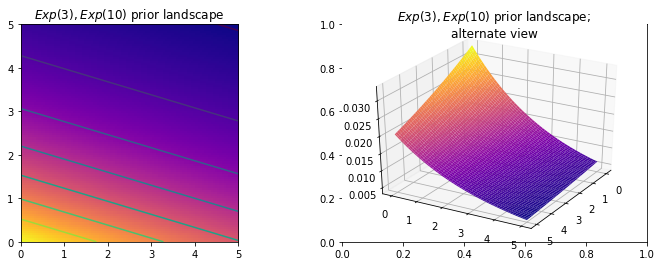

In [3]:
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots(1,2,figsize=[12,4])
exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(x, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])
CS = ax[0].contour(X, Y, M)
im = ax[0].imshow(M, interpolation='none', origin='lower',
                cmap='plasma', extent=(0, 5, 0, 5))
_ = ax[0].set(title ="$Exp(3), Exp(10)$ prior landscape")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap='plasma')
ax.view_init(azim=390)
_ = ax.set(title = "$Exp(3), Exp(10)$ prior landscape; \nalternate view")

If these surfaces describe our prior distributions on the unknowns, what happens to our space after we incorporate our observed data $X$? The data $X$ does not change the space, but it changes the surface of the space by pulling and stretching the fabric of the prior surface to reflect where the true parameters likely live. More data means more pulling and stretching, and our original shape becomes mangled or insignificant compared to the newly formed shape. Less data, and our original shape is more present. Regardless, the resulting surface describes the posterior distribution.

In [5]:
# sample size of data we observe
N = 5

# the true parameters that we don't know
lambda_1_true = 1
lambda_2_true = 3

#...we see the data generated, dependent on the above two values.
data = np.concatenate([
    stats.poisson.rvs(lambda_1_true, size=(N, 1)),
    stats.poisson.rvs(lambda_2_true, size=(N, 1))
], axis=1)
print("observed (2-dimensional,sample size = {}):".format(N, data))

# plotting details.
x = y = np.linspace(.01, 5, 100)
likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x)
                        for _x in x]).prod(axis=1)
likelihood_y = np.array([stats.poisson.pmf(data[:, 1], _y)
                        for _y in y]).prod(axis=1)
L = np.dot(likelihood_x[:, None], likelihood_y[None, :])

observed (2-dimensional,sample size = 5):


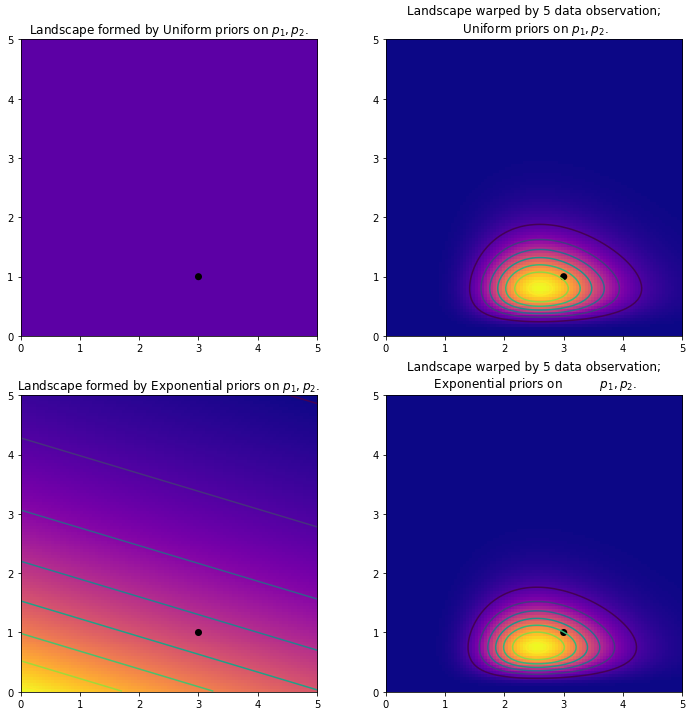

In [6]:
fig, ax = plt.subplots(2,2, figsize=[12,12])
ax = ax.ravel()

uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(x, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = ax[0].imshow(M, interpolation='none', origin='lower',
                cmap='plasma', vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
ax[0].scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
ax[0].set(title = "Landscape formed by Uniform priors on $p_1, p_2$.")

ax[1].contour(x, y, M * L)
im = ax[1].imshow(M * L, interpolation='none', origin='lower',
                cmap='plasma', extent=(0, 5, 0, 5))
ax[1].scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
ax[1].set(title = "Landscape warped by {} data observation;\n Uniform priors on \
$p_1, p_2$.".format(N))


exp_x = stats.expon.pdf(x, loc=0, scale=3)
exp_y = stats.expon.pdf(x, loc=0, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])
ax[2].contour(x, y, M)
im = ax[2].imshow(M, interpolation='none', origin='lower',
                cmap='plasma', extent=(0, 5, 0, 5))
ax[2].scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
ax[2].set(title = "Landscape formed by Exponential priors on $p_1, p_2$.")

# This is the likelihood times prior, that results in the posterior.
ax[3].contour(x, y, M * L)
im = ax[3].imshow(M * L, interpolation='none', origin='lower',
                 cmap='plasma', extent=(0, 5, 0, 5))
ax[3].scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
ax[3].set(title = "Landscape warped by {} data observation;\n Exponential priors on\
          $p_1, p_2$.".format(N))

for i, x in enumerate(ax):
    ax[i].set(xlim = (0,5), ylim = (0,5))

**We should explore the deformed posterior space generated by our prior surface and observed data to find the posterior mountain** Recall that MCMC returns samples from the *posterior* distribution, not the distribution itself. MCMC intelligently searches the space meaning it will hopefully converge towards the areas of high posterior probability. MCMC does this by exploring nearby positions and moving into areas with higher probability. Again, perhaps "converge" is not an accurate term to describe MCMC's progression. Converging usually implies moving towards a point in space, but MCMC moves towards a broader area in the space and randomly walks in that area, picking up samples from that area.

- step 1) Start at current position.
- step 2) Propose moving to a new position
- step 3) Accept/Reject the new position based on the position's adherence to the data and prior distributions (ask if the pebble likely came from the mountain).
- step 4) If you accept: Move to the new position. Return to step 1. Else: Do not move to new position. Return to step 1.
- step 5) After a large number of iterations, return all accepted positions.

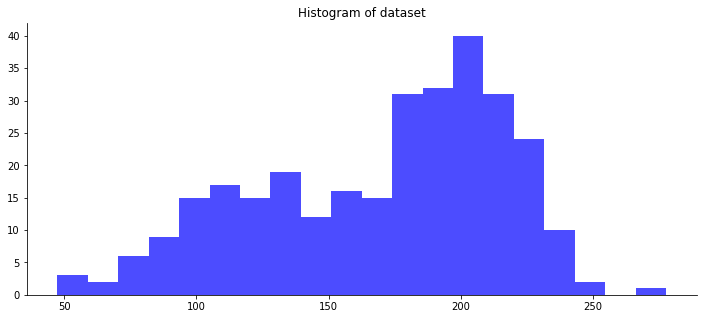

In [7]:
data = np.loadtxt('data/mixture_data.csv', delimiter=',')
fig, ax = plt.subplots(figsize=[12,5])
ax.hist(data, bins=20, color='blue', histtype="stepfilled", alpha=0.7)
ax.set(ylim = (0, None), title = "Histogram of dataset")
remove_borders(ax)

In Bayesian modeling always think HOW the data might have been created. Here the following might apply:

- For each data point, choose cluster 1 with probability $p$, else choose cluster 2.
- Draw a random variate from a Normal distribution with parameters $\mu_i$ and $\sigma_i$ where $i$ was chosen in step 1.
- Repeat.

An appropriate way to assign data points to clusters is to use a **PyMC3 Categorical stochastic variable**. Its parameter is a $k$-length array of probabilities that must sum to one and its value attribute is an integer between 0 and $k-1$ randomly chosen according to the crafted array of probabilities (In our case $k=2$)

In [40]:
with pm.Model() as model:
    p1 = pm.Uniform('p', 0, 1) # p∼Uniform(lower=0.0, upper=1.0)
    p2 = 1 - p1 # theano.tensor.var.TensorVariable
    p = T.stack([p1, p2]) 
    assignment = pm.Categorical('assigment', p, shape = data.shape[0],
                               testval = np.random.randint(0,2, data.shape[0]))

print("prior assignment, with p = {}".format(p1.tag.test_value))
print(assignment.tag.test_value[:10])

prior assignment, with p = 0.5
[0 0 1 0 0 0 0 1 0 0]


Looking at the dataset, the standard deviations of the two Normals are clearly different. To maintain ignorance of what the standard deviations might be, we will initially model them as uniform on 0 to 100. We will include both standard deviations in our model using a single line of PyMC3 code:

    sds = pm.Uniform("sds", 0, 100, shape=2)
    
Then we need to specify priors on the centers ($\mu$) of the clusters. Eye-balling these estimates gives approximatley $\mu_0 = 120$ and $\mu_1 = 190$ and $\sigma_0 = \sigma_1 = 10$.

In [41]:
with model:
    sds = pm.Uniform("sds", 0, 100, shape=2)
    centers = pm.Normal("centers", 
                        mu=np.array([120, 190]), 
                        sd=np.array([10, 10]), 
                        shape=2)
    
    center_i = pm.Deterministic('center_i', centers[assignment])
    sd_i = pm.Deterministic('sd_i', sds[assignment])
    
    # and to combine it with the observations:
    observations = pm.Normal("obs", mu=center_i, sd=sd_i, observed=data)
    
print("Random assignments: ", assignment.tag.test_value[:5])
print("Assigned center: ", center_i.tag.test_value[:5])
print("Assigned standard deviation: ", sd_i.tag.test_value[:5])

Random assignments:  [0 0 1 0 0]
Assigned center:  [120. 120. 190. 120. 120.]
Assigned standard deviation:  [50. 50. 50. 50. 50.]
